In [42]:
import cv2 
import torch 
import matplotlib.pyplot as plt 
from enum import Enum 
import os 
import numpy as np 
import time

class ModelType(Enum): 
    DPT_LARGE = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
    DPT_Hybrid = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
    MIDAS_SMALL = "MiDaS_small" # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

class Midas(): 
    def __init__(self,modelType:ModelType=ModelType.DPT_LARGE): 
        self.midas = torch.hub.load("isl-org/MiDaS", modelType.value)
        self.modelType = modelType

    def useCUDA(self):
        if torch.cuda.is_available():
            print('Using CUDA')
            self.device = torch.device("cuda") 
        else: 
            print('Using CPU')
            self.device = torch.device("cpu")
        self.midas.to(self.device)
        self.midas.eval()

    def transform(self): 
        print('Transform')
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        if self.modelType.value == "DPT_Large" or self.modelType.value == "DPT_Hybrid":
            self.transform = midas_transforms.dpt_transform
        else:
            self.transform = midas_transforms.small_transform
    
    def predict(self,frame): 
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_batch = self.transform(img).to(self.device)
        with torch.no_grad():
            prediction = self.midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=img.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depthMap = prediction.cpu().numpy()
        depthMap = cv2.normalize(depthMap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        depthMap = cv2.applyColorMap(depthMap, cv2.COLORMAP_INFERNO)
        # depthMap = np.flip(depthMap, axis=0)
        return depthMap
    
    def livePredict(self): 
        print('Starting webcam (press q to quit)...')
        capObj = cv2.VideoCapture(0)
        while True: 
            ret,frame = capObj.read()
            t1 = time.time()
            depthMap = self.predict(frame)
            t2 = time.time()
            print(int((t2-t1)*1000))
            #depthMap = cv2.cvtColor(depthMap, cv2.COLOR_BGR2GRAY)

            combined = np.hstack((frame, depthMap))
            
            cv2.imshow('Combined',combined)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        capObj.release()
        cv2.destroyAllWindows()
        


In [43]:
def run(modelType:ModelType):
    midasObj = Midas(modelType)
    midasObj.useCUDA() 
    midasObj.transform() 
    midasObj.livePredict() 





In [44]:
modelType= ModelType.DPT_LARGE
midasObj = Midas(modelType)
midasObj.useCUDA() 
midasObj.transform() 


Using cache found in /home/bhavesh/.cache/torch/hub/isl-org_MiDaS_master


Using CUDA
Transform


Using cache found in /home/bhavesh/.cache/torch/hub/intel-isl_MiDaS_master


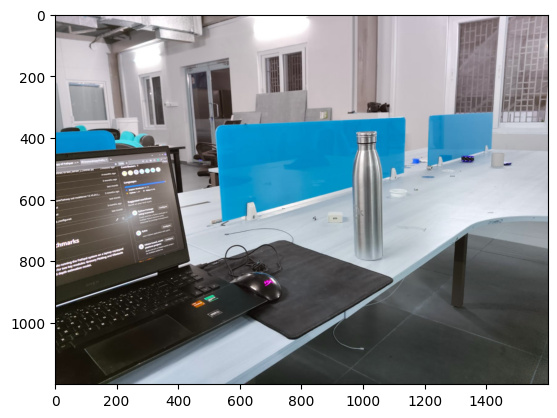

In [45]:

image_path = r"/home/bhavesh/pathpal/depthmap/test_image1.jpg"
image = cv2.imread(image_path)
# print(image)
plt.imshow(image)

(np.float64(-0.5), np.float64(1599.5), np.float64(1199.5), np.float64(-0.5))

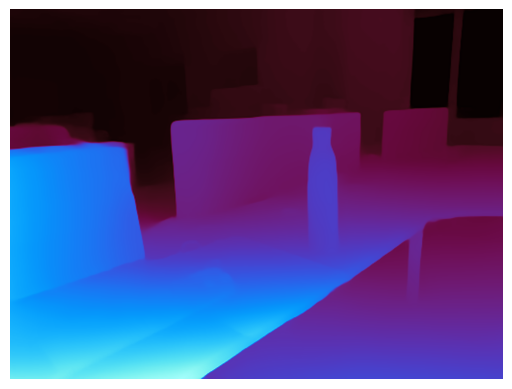

In [53]:

depth_map = midasObj.predict(image) 
plt.imshow(depth_map)
# plt.colorbar()
plt.axis('off')